# Workshop 2 - Implementation
    
In this notebook you will continue to implement the matrix method and check it with some sanity checks.

> ### Task 0
>
> Check whether your implementation of last week was correct using the provided solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

%load_ext autoreload
%autoreload 2

## 1. The Node class
The `Node` class from last week is unchanged and complete

## 2. The Element class

The implementation is incomplete:
- The function `add_distributed_load` should compute the equivalent load vector for a constant load $q$ and moves those loads to the nodes belonging to the element. Remember to use the `add_load` function of the `Node` class to store the equivalent loads (remember we have two nodes per element). Also keep local/global transformations in mind and store `self.q = q` for later use;
- The function `bending_moments` receives the nodal displacements of the element in the global coordinate system (`u_global`) and uses it to compute the value of the bending moment at `num_points` equally-spaced points along the element length. Keep local/global transformations in mind and use the ODE approach in SymPy / Maple / pen and paper to compute an expression for $M$. Do the same for for $w$ in the function `full_displacement`.

> ### Task 2.1
>
> Add the missing pieces to the code, before you perform the checks below.

> ### Task 2.2
>
> Having made your implementations, it is now time to verify the first addition of your code with a simple sanity check. We would like to solve the following simply-supported beam:
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up this problem. After you've added the load, print the element using `print(YOUR ELEMENT)`. Do the shown values for the nodal loads correspond with what you'd expect?

In [2]:
EI = 10
L = 1
q = 5

mm.Node.clear()
mm.Element.clear()

# Define nodes
node1 = mm.Node(0, 0)
node2 = mm.Node(L, 0)

# Define elements
elem = mm.Element(node1, node2)
elem.set_section({'EI': EI})

con = mm.Constrainer()

con.fix_dof(node1, 0)
con.fix_dof(node1, 1)
con.fix_dof(node2, 1)

# Define loads
elem.add_distributed_load([0, q])

K = elem.stiffness()
f = np.zeros(len(K))
f[0:3] = node1.p
f[3:6] = node2.p

In [3]:
print(elem)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[ 0.          2.5        -0.41666667]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0.         2.5        0.41666667]


> ### Task 2.3
>  Now solve the nodal displacements. Once you are done, compare the rotation at the right end of the beam. Does it match the solution you already know?

In [4]:
Kff, Fff = con.constrain(K, f)

u = np.linalg.inv(Kff) @ Fff
print(u[2])

print(1 / 24 * q * L**3 / EI)

0.020833333333333336
0.020833333333333332


> ### Task 2.4
> Calculate the bending moment at midspan and plot the moment distribution using `plot_moment_diagram`. Do the values and shape match with what you'd expect?

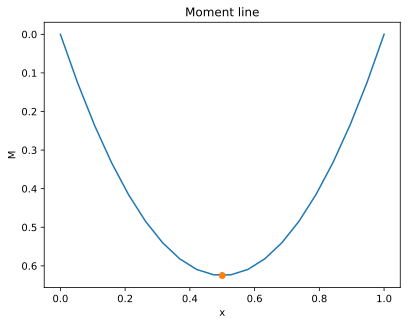

In [5]:
u_elem = con.full_disp(u)
elem.plot_moment_diagram(u_elem, num_points=20)

M_mid_theory = 1 / 8 * q * L**2
plt.plot(L / 2, M_mid_theory, 'o');

> ### Task 2.5
> Calculate the deflection at midspan and plot the deflected structure using `plot_displaced`. Do the values and shape match with what you'd expect?

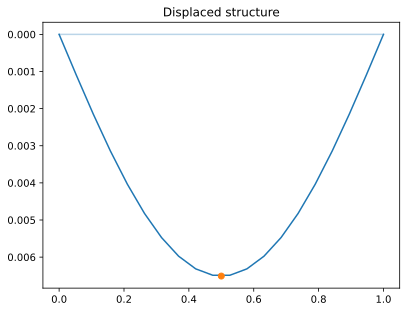

In [6]:
elem.plot_displaced(u_elem, num_points=20)

w_mid_theory = 5 / 384 * q * L**4 / EI
plt.plot(L / 2, w_mid_theory, 'o');

## 3. The Constrainer class

We're going to expand our Constrainer class, but the implementation is incomplete:
- The constrainer class should be able to handle non-zero boundary conditions too. `constrain` should be adapted to do so + the docstring of the class itself. Furthermore, the assert statement of `fix_dof` should be removed.
- The function `support_reactions` is incomplete. Since the constrainer is always first going to get `constrain` called, here we already have access to `self.free_dofs`. Together with `self.cons_dofs`, you should have all you need to compute reactions. Note that `f` is also passed as argument. Make sure you take into account the contribution of equivalent element loads that go directly into the supports without deforming the structure.

> ### Task 3.1
>
> Add the missing pieces to the code and docstring, before you perform the checks below.

> ### Task 3.2
>
> We're going to verify our implementation. Therefore, we're going to solve an extension bar, supported at both ends, with a load $q$.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.2.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Can you say on beforehand what will be the displacements? And what will be the support reactions?
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [7]:
EA = 10
L = 2
q = 5

mm.Node.clear()
mm.Element.clear()

# Define nodes
node1 = mm.Node(0, 0)
node2 = mm.Node(L, 0)

# Define elements
elem = mm.Element(node1, node2)
elem.set_section({'EA': EA})

con = mm.Constrainer()

con.fix_node(node1)
con.fix_node(node2)

# Define loads
elem.add_distributed_load([q, 0])
print(elem)

K = elem.stiffness()
f = np.zeros(len(K))
f[0:3] = node1.p
f[3:6] = node2.p

Kff, Fff = con.constrain(K, f)

u_free = np.linalg.inv(Kff) @ Fff

con.support_reactions(K, u_free, f)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[5. 0. 0.]
with node #2:
 This node has:
 - x coordinate=2,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[5. 0. 0.]


array([-5.,  0.,  0., -5.,  0.,  0.])

> ### Task 3.3
>
> Again, we're going to verify our implementation. Therefore, we're going solve a beam, with a load $F$ and support displacement $\bar w$ for the right support.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.3_new.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0. 0. 0.]
This constrainer has constrained the degrees of freedom: [0, 1, 2, 4] with corresponding constrained values: [0, 0, 0, 0.5])
[ 0.   -0.75]
[  0. -15.  15.  10.]


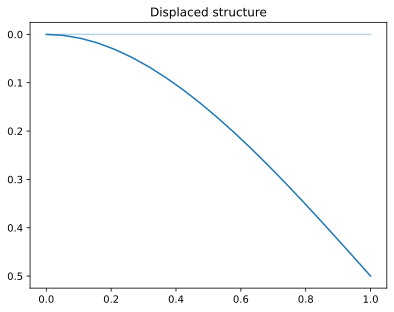

In [8]:
EI = 10
L = 1
F = 5
w = 0.5

mm.Node.clear()
mm.Element.clear()

# Define nodes
node1 = mm.Node(0, 0)
node2 = mm.Node(L, 0)

# Define elements
elem = mm.Element(node1, node2)
elem.set_section({'EI': EI})
print(elem)

con = mm.Constrainer()

con.fix_node(node1)
con.fix_dof(node2, 1, w)
print(con)

# Define loads
node2.add_load([0, F, 0])

K = elem.stiffness()
f = np.zeros(len(K))
f[0:3] = node1.p
f[3:6] = node2.p

Kff, Fff = con.constrain(K, f)

u_free = np.linalg.inv(Kff) @ Fff
u_full = con.full_disp(u_free)

print(u_free)
support_reactions = con.support_reactions(K, u_free, f)
print(support_reactions)

elem.plot_displaced(u_full, num_points=20)

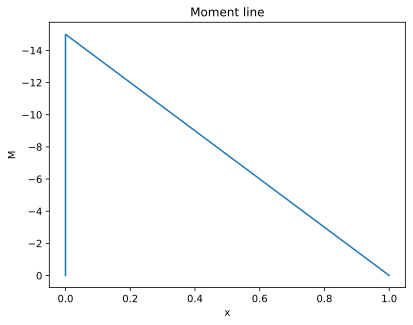

In [9]:
M = elem.plot_moment_diagram(u_full, 10)

In [10]:
print(f'phi1={3 / 2 * w / L}', u_free[1])
print(f'M1={3 * EI / L**2 * w}')
print(f'F1={3 * EI / L**3 * w}', support_reactions[1])
print(f'F2={3 * EI / L**3 * w - F}', support_reactions[3])

phi1=0.75 -0.75
M1=15.0
F1=15.0 -15.0
F2=10.0 10.0
